In [1]:
import requests
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import os
import regex as re
from sklearn.metrics.pairwise import cosine_similarity

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import regex as re
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
import regex as re
from nltk.stem import WordNetLemmatizer 
import json

from scipy.cluster import hierarchy 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
g = globals()
max_d = 7.3

## Call dataframe with assigned topics and rectify errors in the dataframe

In [90]:
final_df =pd.read_csv('./Data/Topic_modelling_final.csv')
final_df['speaker'] = np.where((final_df.speaker.str.contains('George_W._Bush')) & (final_df.Year > 2008), 'Jeb_Bush', final_df.speaker)
final_df['Year'] = np.where((final_df.speaker.str.contains('Ron_Paul')) & (final_df.Year == 2016), 2008, final_df.Year)
final_df['Year'] = np.where((final_df.speaker.str.contains('George_W._Bush')) & (final_df.Year == 2008), 2000, final_df.Year)
final_df['Debate'] = np.where(final_df.speaker.str.contains('Hillary'), 'Democratic', final_df.Debate)

## Doc2Vec

In [701]:
vec = final_df.copy()
final_df.reset_index(inplace = True, drop = True)

In [702]:
#tokenizing text
def tokenize_text(text):
    words = word_tokenize(text)
    return words
final_df['doc2vec_token'] = final_df.doc2vec_text.apply(tokenize_text)

In [703]:

model_list = []
final_df_list = list(final_df.doc2vec_token)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_df_list)]

#Training word2vec model
topic_embedding_model = Doc2Vec(documents, min_count=1, vector_size=20, workers=8, dm=0)

In [704]:
#append back the meta data but this time as a separate column. We will find the document embeddings for this meta data for each document

for i in range(len(final_df)):
    word1 = final_df.iloc[i]['speaker']
    word2 = str(final_df.iloc[i]['Year'])
    word_speaker = word1 + '_' + word2
    topic = final_df.iloc[i]['Topic']
    total = word_speaker + ' ' + topic
    final_df.at[i, 'embedding word'] = total
final_df.drop(columns = 'Unnamed: 0', inplace = True)
final_df.head(3)

,speaker,sentence,Debate,Year,count,new_speaker,len,processed_text,Topic,doc2vec_text,doc2vec_token,embedding word
0,Al_Gore,I would look for justices of the Supreme Cour...,Democratic,2000,1,False,1082,i would look for justices of the supreme court...,Supreme_Court,I would look for justices of the Supreme Cour...,"[I, would, look, for, justices, of, the, Supre...",Al_Gore_2000 Supreme_Court
1,Al_Gore,I agree with that statement. I think it was a...,Democratic,2000,1,False,640,i agree with that statement i think it was a v...,Homosexuality,I agree with that statement. I think it was a...,"[I, agree, with, that, statement, ., I, think,...",Al_Gore_2000 Homosexuality
2,Al_Gore,.. to interpret the Constitution in keeping wi...,Democratic,2000,1,False,69,to interpret the constitution in keeping with ...,Supreme_Court,.. to interpret the Constitution in keeping wi...,"[.., to, interpret, the, Constitution, in, kee...",Al_Gore_2000 Supreme_Court


In [705]:
def get_document_embedding(text, model):
    words = text.split()
    document_vector = topic_embedding_model.infer_vector(words)
    return document_vector

In [706]:
#Get the embeddings 

final_df['embedding'] = final_df['embedding word'].astype(str).apply(lambda x: get_document_embedding(x, model))


In [707]:
embeddings_df = pd.DataFrame(final_df['embedding'].tolist())
embeddings_df.columns = ['embedding_' + str(i) for i in range(embeddings_df.shape[1])]

# Concatenate with the original DataFrame
final_df = pd.concat([final_df, embeddings_df], axis=1)

In [708]:
#find mean of embeddings for each speaker-topic 

embedding_cols = [col for col in final_df if col.startswith('embedding_')]
other_col = ['Debate']

grouped_df = final_df.groupby(['Year', 'speaker','Topic']).agg({**{text_col: 'first' for text_col in other_col}, **{embed_col: 'mean' for embed_col in embedding_cols}}).reset_index()

In [709]:
grouped_df = grouped_df[grouped_df.notna()]

## Cosine Similarities 

In [710]:
#create pairwise similarities 

def sim(debate, year, topic):
    embedding_columns = [f'embedding_{i}' for i in range(20)]
    grouped_df_2 = grouped_df[(grouped_df.Debate == debate)&(grouped_df.Year == year)]
    grouped_df_rep = grouped_df.groupby(['Year', 'Topic'])[embedding_columns].mean().reset_index()
    
    unique_topics = grouped_df_2['Topic'].unique()
    
    similarity_data = {}
    
    
    unique_speakers = grouped_df_2[grouped_df_2['Topic'] == topic]['speaker'].unique()
    similarity_df = pd.DataFrame(index=unique_speakers, columns=unique_speakers)
    
    for speaker in unique_speakers:
        for speaker1 in unique_speakers:

            emb1 = grouped_df_2[(grouped_df_2['speaker'] == speaker) & (grouped_df_2['Topic'] == topic)][embedding_columns].values
            emb2 = grouped_df_2[(grouped_df_2['speaker'] == speaker1) & (grouped_df_2['Topic'] == topic)][embedding_columns].values
        
            if len(emb1) > 0 and len(emb2) > 0:
                sim = cosine_similarity(emb1, emb2)[0][0]
                similarity_df.loc[speaker, speaker1] = sim

    mean_df  = similarity_df.where(~np.eye(similarity_df.shape[0], dtype=bool))
    upper_tri = similarity_df.where(np.triu(np.ones(similarity_df.shape), k=1).astype(bool))
    mean_df['mean_score'] = mean_df.mean(axis = 1)
    mean_df['std'] = upper_tri.stack().std()
    mean_df.sort_values(by = 'mean_score', inplace = True)
    return(mean_df)

In [711]:
#Find the average similarities within the party for that year 

average_scores = pd.DataFrame()
party = 'Republican' #republican or democrat
year = 2016 #2000,20008,2016,2020

topics_lister = pd.DataFrame(grouped_df[(grouped_df.Debate == party)&(grouped_df.Year == year)].Topic.value_counts().sort_values(ascending = False)).reset_index()
topics_lister.rename(columns = {'index':'topic'}, inplace = True)
lists = topics_lister.topic.tolist()
speakers = ['George_W._Bush', 'Joe_Biden', 'Barack_Obama', 'Donald_Trump']
pattern = '|'.join(speakers) 
for i in lists:
    df = sim(party, year, i)
    df.reset_index(inplace = True)
    df.rename(columns = {'index':'speaker'}, inplace = True)
    df.rename(columns={'mean_score': f'mean_score_{i}'}, inplace=True) 
    contains_speakers = df.speaker.str.contains(pattern).any()
    
    if (contains_speakers) &\
    (len(df) >= 0.8*len(grouped_df[(grouped_df.Debate == party)&(grouped_df.Year == year)].speaker.unique())):
        if average_scores.empty:
            average_scores = df[['speaker', f'mean_score_{i}']].copy()
        else:
            average_scores = average_scores.merge(df[['speaker', f'mean_score_{i}']], on='speaker', how='outer')    

In [712]:
average_scores['final_mean'] = average_scores.mean(axis = 1)
average_scores = average_scores.sort_values(by = 'final_mean')
average_scores['speaker'] = average_scores.speaker.str.replace('_',' ')

#Uncomment. replace president name for the year we are plotting for 
# average_scores['speaker'] = average_scores.speaker.str.replace('Joe Biden','Joe Biden \n(POTUS)')

#Uncomment for 2020
# average_scores['speaker'] = average_scores.speaker.str.replace('Elizabeth Warren','Elizabeth \nWarren')
# average_scores['speaker'] = average_scores.speaker.str.replace('Michael Bloomberg','Michael \nBloomberg')
# average_scores['speaker'] = average_scores.speaker.str.replace('Pete Buttigieg','Pete \nButtigieg')
# average_scores['speaker'] = average_scores.speaker.str.replace('Amy Klobuchar','Amy \nKlobuchar')

<Figure size 900x300 with 0 Axes>

<Axes: xlabel='speaker', ylabel='final_mean'>

Text(0.5, 1.0, 'Similarity amongst Democratic Presidential Primary Candidates (2020)')

Text(0.5, 0, 'Candidate')

Text(0, 0.5, 'Cosine Similarity Score')

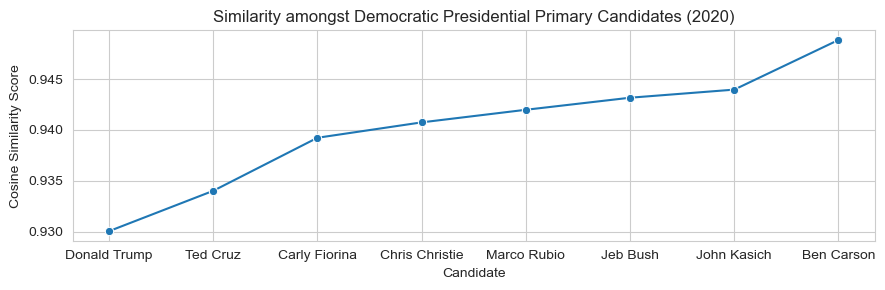

In [713]:
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(9, 3))
sns.lineplot(data=average_scores, x='speaker', y='final_mean', marker='o')

# Enhance the plot with titles and labels
plt.title('Similarity amongst Democratic Presidential Primary Candidates (2020)')
plt.xlabel('Candidate')
plt.ylabel('Cosine Similarity Score')
# plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

## Clustering

In [714]:
#for clustering we combine all documents per unique speaker 
def combine_texts(group):
    combined = '. '.join(group['sentence']) + '. '
    return combined
vec.reset_index(inplace = True, drop = True)
grouped_texts = vec.groupby(['Year', 'Debate', 'speaker']).apply(combine_texts).reset_index(name='combined_text')


In [715]:
def pre_processor(x):
    regex = r'\[.*?\]'
    regex_punctuation = r'[^\w\s]'

    x = re.sub(regex, '', x)
    x = re.sub(' +', ' ', x)
    x = re.sub(regex_punctuation, '', x)
    x = x.lower()
    words = word_tokenize(x)
    if len(words)>=5:
        filtered_words = [word for word in words if word.lower() and word.isalnum()]
    else:
        filtered_words = 'delete'
    return ' '.join(filtered_words)

In [716]:
#Pre-Processing and tokenization

grouped_texts['processed_text'] =grouped_texts.combined_text.apply(pre_processor)
grouped_texts = grouped_texts[grouped_texts.processed_text != 'd e l e t e']

grouped_texts = grouped_texts.reset_index(drop = True)

grouped_texts['speaker'] = grouped_texts.speaker.str.replace(' ','_', regex =True)+'_'+grouped_texts.Year.astype(str)

grouped_texts['doc2vec_text'] = grouped_texts.processed_text + ' ' + grouped_texts.speaker 

grouped_texts['doc2vec_token'] = grouped_texts.doc2vec_text.apply(tokenize_text)

grouped_texts.reset_index(inplace = True, drop = True)


In [717]:
#Doc2vec embeddings 
final_df_list_cluster = list(grouped_texts.doc2vec_token)
documents_cluster = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_df_list_cluster)]
overall_model= Doc2Vec(documents_cluster, min_count=1, vector_size=20, workers=8, dm=0)

In [718]:

#append the document vectors each vector element as a feature
doc_vectors = []
check_df = vec.copy()
for i in range(len(documents_cluster)):
    vector = overall_model.dv[i] 
    doc_vectors.append(vector)

# Create a DataFrame from the document vectors
vector_df = pd.DataFrame(doc_vectors, columns=[f'vector_{i}' for i in range(20)])

for i in range(20):
    grouped_texts[f'vector_{i}'] = vector_df[f'vector_{i}']


In [719]:
#Extract our feature Columns 
features = grouped_texts[[f'vector_{i}' for i in range(20)]]

### Hierarchical

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Dendogram Analysis of Presidential Canadidate Clusters')

Text(0.5, 0, 'Candidates (Indexed by unique number)')

Text(0, 0.5, 'Distance between clusters')

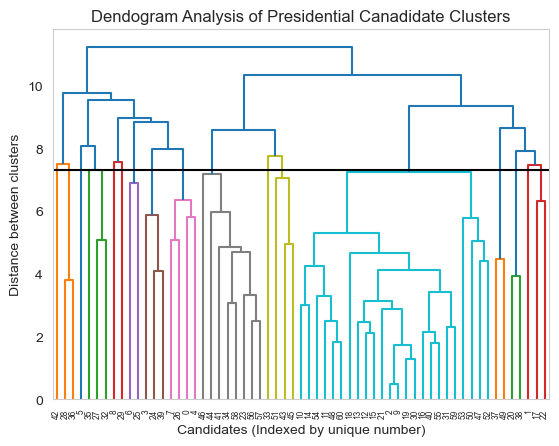

In [722]:

  
Z = hierarchy.linkage(features, method='ward') 
plt.figure() 
plt.title("Dendogram Analysis of Presidential Canadidate Clusters") 
dendrogram = hierarchy.dendrogram(Z) 
  
# Cutting the dendrogram at max_d 
plt.axhline(y=max_d, c ='k') 
plt.xlabel('Candidates (Indexed by unique number)')
plt.ylabel('Distance between clusters')
plt.grid(False)

plt.show()

In [357]:
n_clusters = 17   # Adjust this based on your specific needs

# Initialize the Agglomerative Clustering model
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

# Fit the model and predict clusters
cluster_labels = clustering.fit_predict(features)

# Assign the cluster labels to your original DataFrame
grouped_texts['cluster'] = cluster_labels

In [693]:
#Exploring Clusters 
#Large output. Uncomment if needed 

# for i in range(0,17):
#     grouped_texts[['speaker','Debate', 'Year','cluster']][grouped_texts.cluster == i]

In [196]:
##EVALUATION

Z = linkage(features, method='ward')
c, coph_dists = cophenet(Z, pdist(features))
print("Cophenetic Correlation Coefficient:", c)

Cophenetic Correlation Coefficient: 0.7200330026833497


## Experimentation with other clustering Methods. Suboptimal Results

**DBSCAN**

In [537]:


# Parameters for DBSCAN
eps = 5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 5  # The number of samples in a neighborhood for a point to be considered as a core point

# Initialize DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit and predict clusters
cluster_labels = dbscan.fit_predict(features)

# Assign the cluster labels to your DataFrame
grouped_texts['cluster'] = cluster_labels

#regardless of eps and min_samples, clusters do not make sense 

In [538]:
cluster_labels

array([-1, -1,  0, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0, -1,  0, -1,  0, -1,  0,  0, -1, -1, -1,  0, -1,  0,  0,
       -1, -1,  0, -1, -1, -1, -1,  0,  0,  0, -1,  0, -1, -1,  0, -1, -1,
        0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

**Kmeans**

Both Elbow Plot and knee plot give very uninterpretable results in order to make selection on cluster choice

In [568]:


g =globals()
elbow_plot_list = []
sil_score_list = []
def kmeans_maker(i, df = features):
    kmeans = KMeans(n_clusters=i, init='random', random_state=29, n_init = 'auto')
    km_clusters = kmeans.fit_predict(df)
    g['elbow_plot_list'].append([i,kmeans.inertia_])
    
    label=kmeans.predict(df)
    g['sil_score_list'].append([i,silhouette_score(df, label)])

In [570]:

for i in range(2,15):
    kmeans_maker(i)
elbow_plot_df_1 = pd.DataFrame(elbow_plot_list)
elbow_plot_df_1.rename(columns = {0:'Number of Clusters',1:'SSE'}, inplace = True)
sil_score_df_1 = pd.DataFrame(sil_score_list)
sil_score_df_1.rename(columns = {0:'Number of Clusters',1:'Silhoutte Score'}, inplace = True)

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'Elbow Plot of SSE and Number of Clusters')

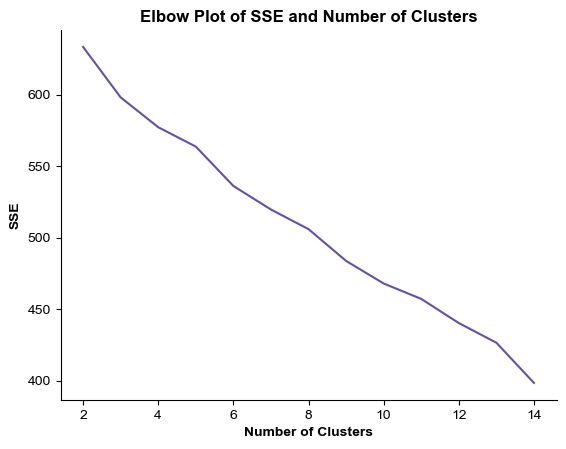

In [571]:
a = sns.lineplot(data=elbow_plot_df_1, x='Number of Clusters', y='SSE', color = '#674ea7')
sns.set_style("whitegrid", {'grid.color': '0.8'})
sns.despine()
plt.xlabel('Number of Clusters' , fontweight = 'bold')
plt.ylabel('SSE' , fontweight = 'bold')
plt.title('Elbow Plot of SSE and Number of Clusters', fontweight = 'bold')
plt.show()

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Silhouette Coefficient')

Text(0.5, 1.0, 'Knee Plot of Silhoutte Coefficient and Number of Clusters')

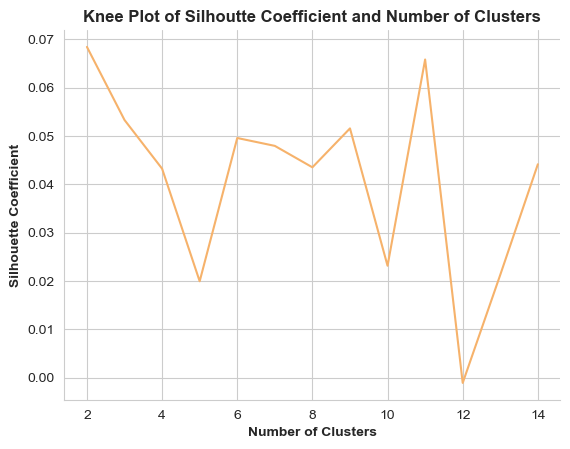

In [572]:
b = sns.lineplot(data=sil_score_df_1, x='Number of Clusters', y='Silhoutte Score', color  = '#f6b26b')
sns.set_style("whitegrid", {'grid.color': '0.8'})
sns.despine()
plt.xlabel('Number of Clusters' , fontweight = 'bold')
plt.ylabel('Silhouette Coefficient', fontweight = 'bold')
plt.title('Knee Plot of Silhoutte Coefficient and Number of Clusters', fontweight = 'bold')
plt.show()